# Interactions entre élèves et enseignants d’une école (Données issues de BMC Infectious Diseases, 2014)
- Construction du graphe 
- Analyse des propriétés topologiques du graphe (Distribution des degrés, Clustering et Centralités [degré, betweenness, closeness, PageRank, Katz])
- Marche aléatoire 
- Comparaison avec des modèles de réseaux de référence (Erdős–Rényi, Barabási–Albert et Watts–Strogatz)
- Détection des communautés
- Dynamique de consensus 
- Stabilité de Markov  
- Détermination de la matrice de contact entre classes
- Simulation de la propagation épidémique (modèle SIR)

In [266]:
import pandas as pd
import pandas as pd
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch
from networkx.algorithms import community as nx_community
from sklearn.cluster import SpectralClustering
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from collections import defaultdict, Counter
from community import community_louvain
from community import community_louvain
from sklearn.cluster import SpectralClustering
import community as community_louvain
from collections import defaultdict
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la
import random
random.seed(42)


In [267]:
df = pd.read_csv("data/primaryschool_cleaned.csv",delimiter="\t",header=None)
df.head()

0     1     2   3   4
0  31220  1558  1567  3B  3B
1  31220  1560  1570  3B  3B
2  31220  1567  1574  3B  3B
3  31220  1632  1818  4B  4B
4  31220  1632  1866  4B  4B

# Construction du graphe

Nombre de noeuds: 242
Nombre d'arêtes: 8317
134
16634


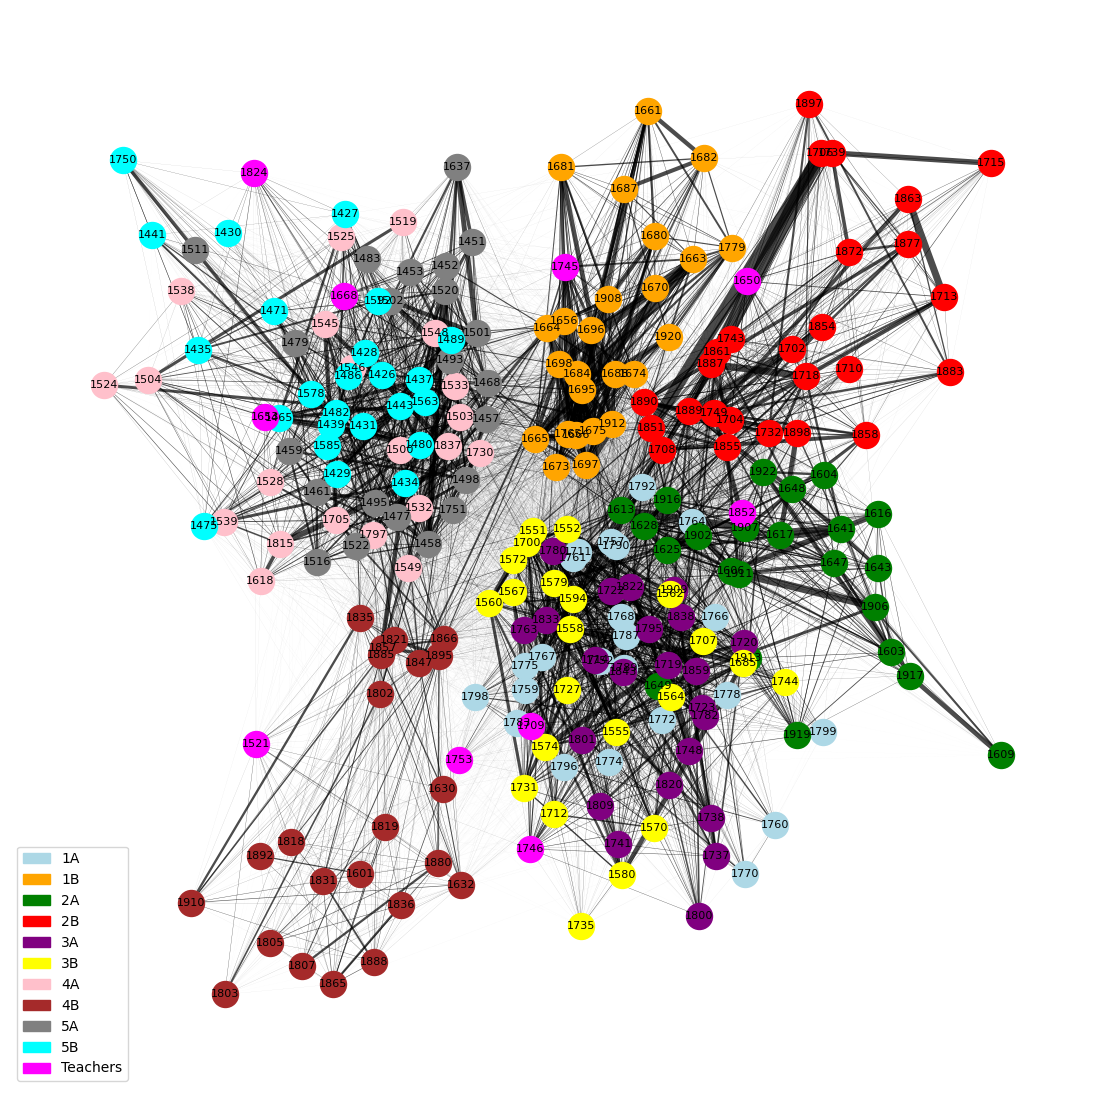

In [268]:
G = nx.Graph()

# Construction du graphe
for (i, j), group in df.groupby([1, 2]):
    Si, Sj = group[3].iloc[0], group[4].iloc[0]   # catégories
    total_t = group[0].sum()                       # somme des temps de contact

    # Ajouter les noeuds et arêtes
    G.add_nodes_from([
        (i, {"category": Si}),
        (j, {"category": Sj})
    ])
    G.add_edge(i, j, t=total_t)
    
print(f"Nombre de noeuds: {G.number_of_nodes()}")
print(f"Nombre d'arêtes: {G.number_of_edges()}")
print(max(dict(G.degree()).values()))
print(sum(dict(G.degree()).values()))

# Coloration des noeuds par catégories

color_map = {
    "1A": "lightblue",   
    "1B": "orange",      
    "2A": "green",     
    "2B": "red",
    "3A": "purple",
    "3B": "yellow",
    "4A": "pink",
    "4B": "brown",
    "5A": "gray",
    "5B": "cyan",
    "Teachers": "magenta"
    
}
node_colors = [color_map.get(G.nodes[n]["category"], "black") for n in G.nodes()]

# Layout du graphe

pos = nx.spring_layout(G, seed=42)  # Calculer le layout une seule fois

# Ponderation sur les arêtes

edge_weights = [G[u][v]["t"] for u, v in G.edges()]
max_w = max(edge_weights) or 1
edge_widths = [10 * (w / max_w) for w in edge_weights]

# Construction  du graphe

plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
for cat, color in color_map.items():
    nodes = [n for n, attr in G.nodes(data=True) if attr["category"] == cat]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=350, label=cat)

nx.draw_networkx_labels(G, pos, font_size=8)

# Ajouter la légende
legend_handles = [mpatches.Patch(color=color, label=cat) for cat, color in color_map.items()] # Créer des patches pour la légende(rectangles de couleur)
plt.legend(handles=legend_handles, loc='best')
plt.axis("off")
plt.show()

Touver le noeud correspondant à ce degré maximal

In [269]:
degree_dict = dict(G.degree())
max_degree = max(degree_dict.values())

# Trouver le(s) nœud(s) avec ce degré
max_nodes = [n for n, d in degree_dict.items() if d == max_degree]

# Afficher leur catégorie
for n in max_nodes:
    print(n, G.nodes[n]['category'])
    print(max_degree)


1551 3B
134


In [270]:
print(list(G.edges(data=True))[:10])

[(1426, 1427, {'t': 2191220}), (1426, 1428, {'t': 3110160}), (1426, 1429, {'t': 4083620}), (1426, 1430, {'t': 848940}), (1426, 1431, {'t': 4984620}), (1426, 1434, {'t': 789820}), (1426, 1435, {'t': 1019500}), (1426, 1437, {'t': 1662120}), (1426, 1439, {'t': 2657320}), (1426, 1441, {'t': 870460})]


# Analyse des propriétés topologiques du graphe (Distribution des degrés, Clustering et Centralités [degré, betweenness, closeness, PageRank, Katz])

Dégré de distribution

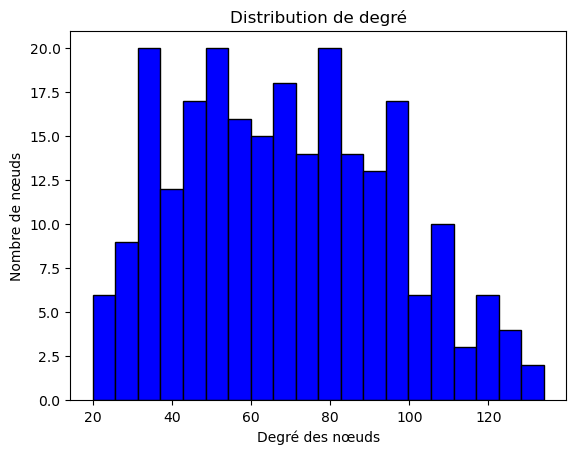

In [294]:
import matplotlib.pyplot as plt
degrees = [d for n, d in G.degree()]
plt.hist(degrees, bins=20, color='blue', edgecolor='black')
plt.xlabel("Degré des nœuds")
plt.ylabel("Nombre de nœuds")
plt.title("Distribution de degré")
plt.show()


Distribution en fonction des éléves et teachers

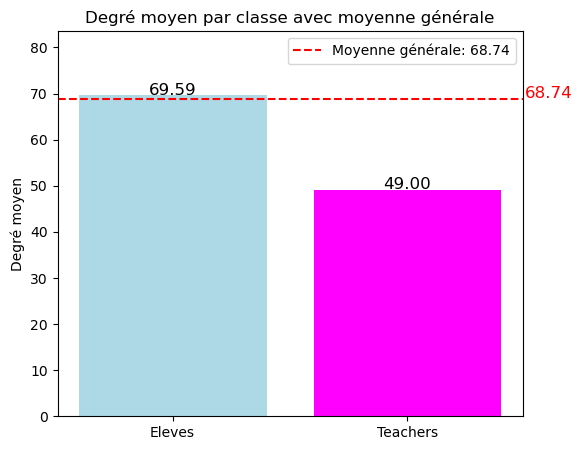

In [272]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Regrouper les nœuds en deux classes : Eleves et Teachers
class_groups = defaultdict(list)
for n, attr in G.nodes(data=True):
    if attr["category"] == "Teachers":
        class_groups["Teachers"].append(n)
    else:
        class_groups["Eleves"].append(n)

# Calculer la moyenne des degrés par classe
mean_degree_per_class = {}
for cls, nodes in class_groups.items():
    degrees = [G.degree(n) for n in nodes]
    mean_degree_per_class[cls] = np.mean(degrees)

# Calculer la moyenne générale
all_degrees = [G.degree(n) for n in G.nodes()]
mean_global = np.mean(all_degrees)

# Affichage du graphique
classes = list(mean_degree_per_class.keys())
means = [mean_degree_per_class[cls] for cls in classes]
colors = ["lightblue", "magenta"]  # Eleves, Teachers

plt.figure(figsize=(6, 5))
bars = plt.bar(classes, means, color=colors)

# Ajouter la valeur moyenne sur chaque barre
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f"{mean:.2f}", ha='center', fontsize=12)

# Tracer la moyenne générale
plt.axhline(mean_global, color='red', linestyle='--', label=f"Moyenne générale: {mean_global:.2f}")
plt.text(1.5, mean_global + 0.2, f"{mean_global:.2f}", color='red', fontsize=12)

plt.ylabel("Degré moyen")
plt.title("Degré moyen par classe avec moyenne générale")
plt.ylim(0, max(max(means)*1.2, mean_global*1.2))
plt.legend()
plt.show()


Centralités [degré, betweenness, closeness, PageRank, Katz]

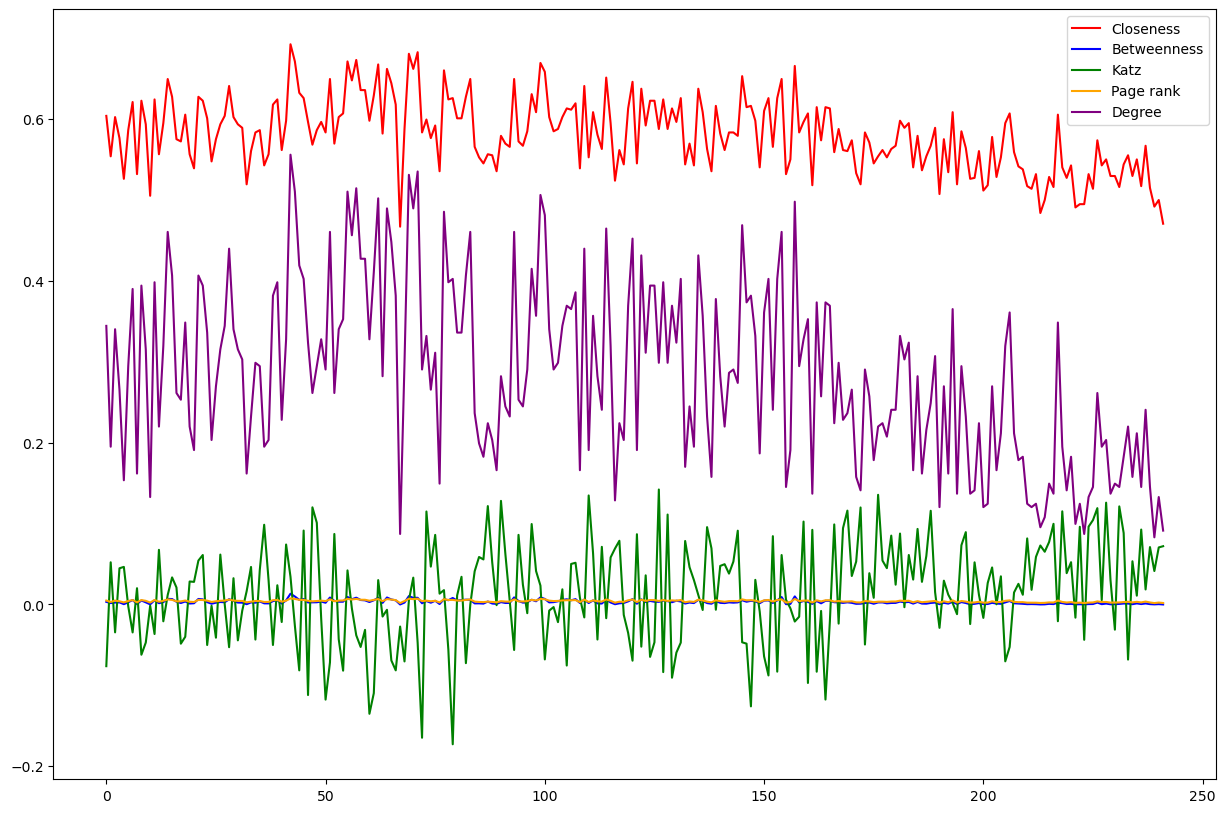

Closeness  vs  Betweenness : Pearson = PearsonRResult(statistic=0.9131674000734534, pvalue=1.5950271082817747e-95) , Spearman = SignificanceResult(statistic=0.9509914847372758, pvalue=2.490268797857423e-124)
Closeness  vs  Katz : Pearson = PearsonRResult(statistic=-0.41037972847904647, pvalue=3.0113345353155404e-11) , Spearman = SignificanceResult(statistic=-0.4540582598522259, pvalue=1.0351103499492103e-13)
Closeness  vs  Page rank : Pearson = PearsonRResult(statistic=0.9913766557236651, pvalue=7.845279746162232e-214) , Spearman = SignificanceResult(statistic=0.9963191938097894, pvalue=4.505284594695216e-258)
Betweenness  vs  Katz : Pearson = PearsonRResult(statistic=-0.2834367255106344, pvalue=7.5135856544588515e-06) , Spearman = SignificanceResult(statistic=-0.3155537943668209, pvalue=5.384127385058497e-07)
Betweenness  vs  Page rank : Pearson = PearsonRResult(statistic=0.9338328933481531, pvalue=3.874185691575921e-109) , Spearman = SignificanceResult(statistic=0.9613935575208052, p

In [ ]:

clC = nx.closeness_centrality (G)
bC = nx.betweenness_centrality (G)
kC = nx.katz_centrality_numpy (G)
prC = nx.pagerank (G)
degC = nx.degree_centrality (G)

keys = G.nodes ()
correlations = [[clC[k] for k in keys], [bC[k] for k in keys], [kC[k] for k in keys], [prC[k] for k in keys], [degC[k] for k in keys]]
names = ['Closeness', 'Betweenness', 'Katz', 'Page rank', 'Degree']


colors = ['red', 'blue', 'green', 'orange', 'purple']  # une couleur par mesure

plt.figure(figsize=(15,10))
for i in range(len(names)):
    plt.plot(correlations[i], label=names[i], color=colors[i])
plt.legend()
plt.show()



from scipy import stats


for i in range (4):
    for j in range (i + 1, 4):
        print (names[i], ' vs ', names[j], ': Pearson =', stats.pearsonr (correlations[i], correlations[j]), ', Spearman =', stats.spearmanr (correlations[i], correlations[j]))

In [274]:
# Calcul des principales mesures de centralité du graphe

degree = dict(G.degree)

betw = nx.betweenness_centrality(G)

G_for_closeness = G.copy()


close = nx.closeness_centrality(G_for_closeness)

pagerank = nx.pagerank(G)

avg_neigh_deg = nx.average_neighbor_degree(G)

katz = nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0) 

df_cent = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]["category"] for n in G.nodes()],
    "degree": [degree[n] for n in G.nodes()],
    "betweenness": [betw[n] for n in G.nodes()],
    "closeness": [close[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
    "avg_neighbor_degree": [avg_neigh_deg[n] for n in G.nodes()],
    "katz": [katz[n] for n in G.nodes()]
})

df_cent.head()

node category  degree  betweenness  closeness  pagerank  \
0  1426       5B      83     0.003233   0.604010  0.004828   
1  1427       5B      47     0.001705   0.554023  0.003084   
2  1428       5B      82     0.002367   0.602500  0.004762   
3  1429       5B      64     0.002595   0.576555  0.003907   
4  1430       5B      37     0.000343   0.526201  0.002526   

   avg_neighbor_degree      katz  
0            81.903614 -0.076307  
1            68.148936  0.052129  
2            81.792683 -0.034500  
3            78.718750  0.044721  
4            72.567568  0.046436

Affichage des valeurs maximale de centralité et le noeud correspondant 

In [275]:
for col in ['betweenness', 'closeness', 'pagerank', 'katz']:
    idx = df_cent[col].idxmax()
    print(f"\nCentralité : {col}")
    print(f"Noeud : {df_cent.loc[idx, 'node']}")
    print(f"Catégorie : {df_cent.loc[idx, 'category']}")
    print(f"Valeur max : {df_cent.loc[idx, col]}")


Centralité : betweenness
Noeud : 1551
Catégorie : 3B
Valeur max : 0.013270962739313347

Centralité : closeness
Noeud : 1551
Catégorie : 3B
Valeur max : 0.6925287356321839

Centralité : pagerank
Noeud : 1551
Catégorie : 3B
Valeur max : 0.007405998471476617

Centralité : katz
Noeud : 1743
Catégorie : 2B
Valeur max : 0.14210938629844547


Clustering

In [276]:
def clustering_stats_by_category(G):
    clust = nx.clustering(G)
    # Regrouper les noeuds par catégorie
    categories = {}
    for node in G.nodes():
        cat = G.nodes[node].get("category", None)
        if cat is None:
            continue
        if cat not in categories:
            categories[cat] = []
        categories[cat].append(clust[node])
    avg_by_cat = {cat: sum(vals) / len(vals) for cat, vals in categories.items()}
    return avg_by_cat

stats_by_cat = clustering_stats_by_category(G)

print("Clustering moyen par catégorie :")
for cat, val in stats_by_cat.items():
    print(f"  {cat}: {val:.4f}")

moyen_global = sum(nx.clustering(G).values()) / G.number_of_nodes()
print(f"Clustering moyen global : {moyen_global:.4f}")

Clustering moyen par catégorie :
  5B: 0.5685
  5A: 0.5123
  4A: 0.5433
  3B: 0.5091
  2A: 0.5098
  4B: 0.5153
  1B: 0.4887
  2B: 0.5817
  1A: 0.4901
  3A: 0.5366
  Teachers: 0.5122
Clustering moyen global : 0.5255


Visualisation du coefficient de clustering en fonction des ctégories

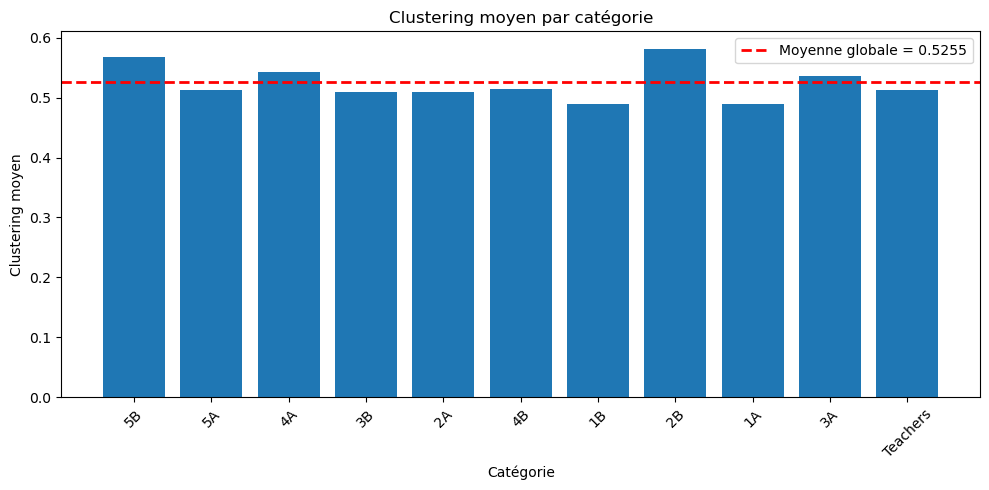

/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_86014/1514364140.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cat.values(), labels=data_by_cat.keys())


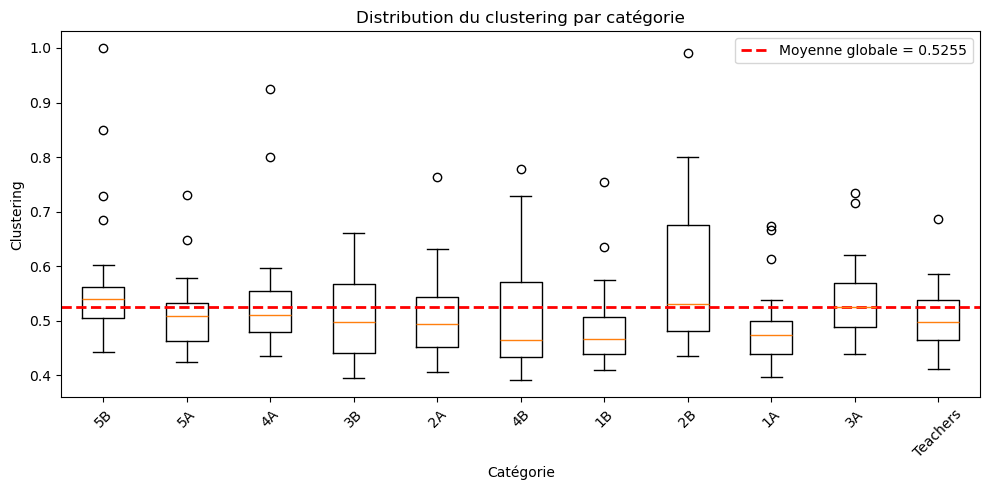

In [277]:
import matplotlib.pyplot as plt
import networkx as nx

# ---- 1. Calcul des valeurs ----
clust = nx.clustering(G)

# Regrouper les valeurs par catégorie
data_by_cat = {}
for node, data in G.nodes(data=True):
    cat = data.get("category")
    if cat is None:
        continue
    data_by_cat.setdefault(cat, []).append(clust[node])

# Moyennes par catégorie
avg_by_cat = {cat: sum(vals) / len(vals) for cat, vals in data_by_cat.items()}

# Moyenne globale
global_mean = sum(clust.values()) / len(clust)


# ---- 2. Visualisation : Moyenne (Barplot) ----
plt.figure(figsize=(10, 5))
plt.bar(avg_by_cat.keys(), avg_by_cat.values())

# Ligne horizontale = moyenne globale
plt.axhline(global_mean, color="red", linestyle="--", linewidth=2, label=f"Moyenne globale = {global_mean:.4f}")

plt.title("Clustering moyen par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Clustering moyen")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# ---- 3. Visualisation : Distribution (Boxplot) ----
plt.figure(figsize=(10, 5))
plt.boxplot(data_by_cat.values(), labels=data_by_cat.keys())

# Ligne horizontale = moyenne globale
plt.axhline(global_mean, color="red", linestyle="--", linewidth=2, label=f"Moyenne globale = {global_mean:.4f}")

plt.title("Distribution du clustering par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Clustering")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Macheur Aléatoire

Affichage et recupration de mean_interaction pour definir le step 

In [ ]:
import numpy as np

# récupérer le degré (nombre d'interactions) de chaque nœud
degrees = [deg for _, deg in G.degree()]
# calcul de la moyenne
mean_interaction = np.mean(degrees)
print("Moyenne d'interaction :", mean_interaction)


Moyenne d'interaction : 68.73553719008264


In [295]:
import random
import networkx as nx

def random_walk(G, steps=68):
    visited = []

    # 1) Choisir un nœud au hasard
    current = random.choice(list(G.nodes()))
    visited.append(current)

    for _ in range(steps):
        neighbors = list(G.neighbors(current))

        # 2) Si pas de voisins → nouveau point de départ
        if len(neighbors) == 0:
            current = random.choice(list(G.nodes()))
            visited.append(current)
            continue

        # 3) Choisir un voisin non visité si possible
        unvisited_neighbors = [n for n in neighbors if n not in visited]

        if len(unvisited_neighbors) > 0:
            current = random.choice(unvisited_neighbors)
        else:
            # si tous les voisins sont déjà visités → choisir parmi tous les voisins
            current = random.choice(neighbors)

        visited.append(current)

    return visited

# Exemple d'utilisation avec votre graphe G

walk1 = random_walk(G, steps=68)
walk2 = random_walk(G, steps=68)

print("Marche 1 :", walk1)
print("Marche 2 :", walk1)


Marche 1 : [1738, 1783, 1908, 1625, 1606, 1916, 1682, 1567, 1780, 1532, 1767, 1564, 1761, 1789, 1768, 1594, 1859, 1795, 1562, 1800, 1760, 1489, 1797, 1837, 1430, 1824, 1429, 1471, 1427, 1851, 1663, 1661, 1680, 1656, 1757, 1628, 1684, 1675, 1698, 1538, 1525, 1670, 1697, 1843, 1723, 1613, 1720, 1737, 1714, 1855, 1695, 1801, 1560, 1572, 1555, 1558, 1746, 1753, 1687, 1503, 1664, 1437, 1458, 1730, 1906, 1609, 1647, 1912, 1833]
Marche 2 : [1738, 1783, 1908, 1625, 1606, 1916, 1682, 1567, 1780, 1532, 1767, 1564, 1761, 1789, 1768, 1594, 1859, 1795, 1562, 1800, 1760, 1489, 1797, 1837, 1430, 1824, 1429, 1471, 1427, 1851, 1663, 1661, 1680, 1656, 1757, 1628, 1684, 1675, 1698, 1538, 1525, 1670, 1697, 1843, 1723, 1613, 1720, 1737, 1714, 1855, 1695, 1801, 1560, 1572, 1555, 1558, 1746, 1753, 1687, 1503, 1664, 1437, 1458, 1730, 1906, 1609, 1647, 1912, 1833]


Intersection entre les marcheurs(1 et 2)

In [296]:
marche1 = [1890, 1604, 1765, 1764, 1911, 1859, 1902, 1647, 1532, 1653, 1852, 1648, 1919, 1802, 1702, 1739, 1682, 1661, 1666, 1730, 1763, 1719, 1741, 1712, 1552, 1628, 1880, 1727, 1501, 1480, 1753, 1434, 1486, 1792, 1783, 1548, 1503, 1493, 1520, 1824, 1745, 1617, 1837, 1789, 1680, 1656, 1908, 1674, 1731, 1594, 1708, 1822, 1820, 1883, 1898, 1916, 1684, 1732, 1838, 1458, 1495, 1468, 1780, 1738, 1574, 1711, 1457, 1815, 1895]

marche2 = [1798, 1458, 1522, 1459, 1428, 1453, 1495, 1452, 1479, 1461, 1637, 1907, 1666, 1601, 1632, 1857, 1819, 1757, 1548, 1430, 1528, 1887, 1898, 1552, 1567, 1859, 1768, 1800, 1714, 1743, 1897, 1877, 1685, 1663, 1451, 1912, 1787, 1700, 1837, 1618, 1649, 1500, 1524, 1653, 1815, 1560, 1711, 1775, 1698, 1822, 1737, 1572, 1628, 1704, 1710, 1916, 1890, 1908, 1673, 1919, 1906, 1648, 1852, 1643, 1922, 1604, 1838, 1820, 1863]

# conversion en ensembles
set1 = set(marche1)
set2 = set(marche2)

# noeuds communs
noeuds_communs = set1.intersection(set2)

print("Noeuds communs : ", noeuds_communs)
print("Nombre de noeuds communs :", len(noeuds_communs))


Noeuds communs :  {1666, 1548, 1552, 1815, 1820, 1822, 1837, 1838, 1711, 1458, 1852, 1859, 1604, 1495, 1628, 1890, 1898, 1648, 1908, 1653, 1916, 1919}
Nombre de noeuds communs : 22


Visualisation des marches aléatoires sur le graphe

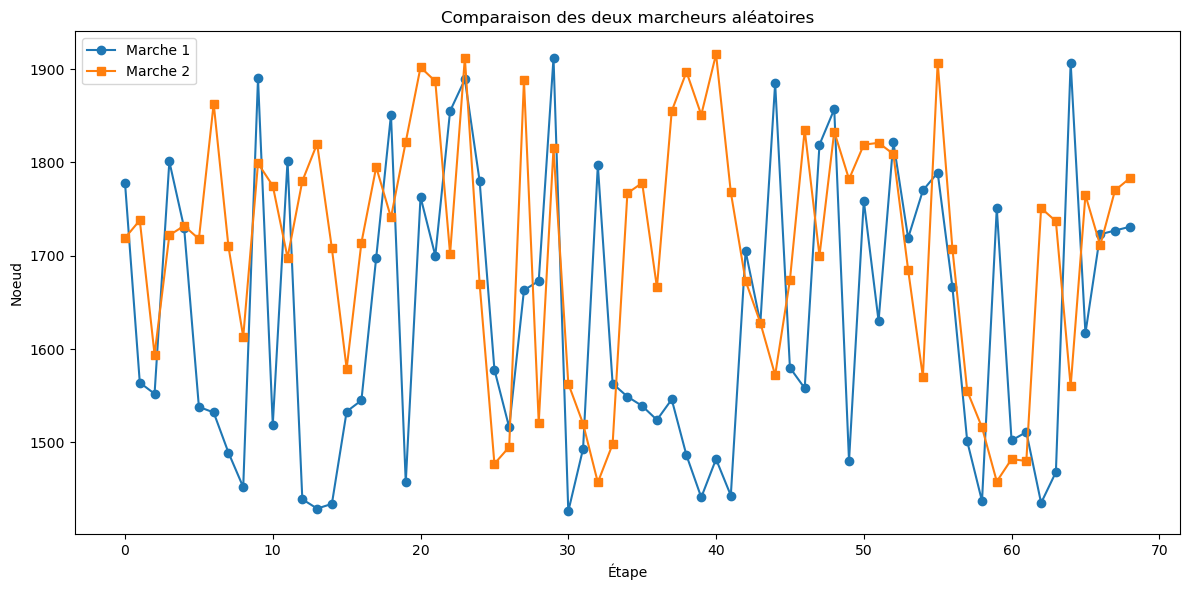

In [281]:
plt.figure(figsize=(12,6))

plt.plot(walk1, marker='o', label='Marche 1')   # sans couleur imposée
plt.plot(walk2, marker='s', label='Marche 2')   # sans couleur imposée

plt.title("Comparaison des deux marcheurs aléatoires")
plt.xlabel("Étape")
plt.ylabel("Noeud")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# Model de réseau (Comparaison avec des modèles de réseaux de référence [Erdős–Rényi, Barabási–Albert et Watts–Strogatz])

Réseau réel : Clustering=0.0072, Modularité=0.6699
ER : Clustering=0.2839, Modularité=0.0814
BA : Clustering=0.3336, Modularité=0.0878
WS : Clustering=0.5767, Modularité=0.3874


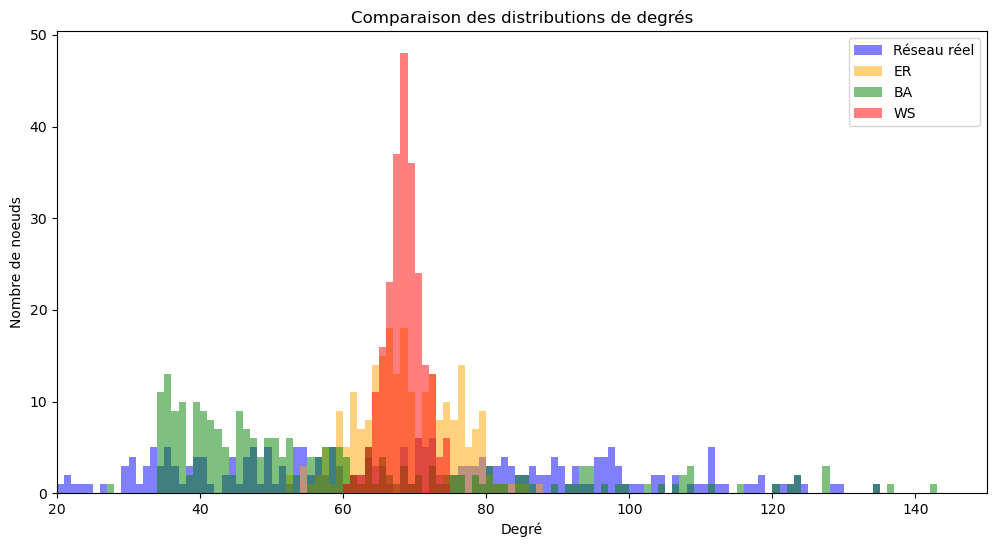

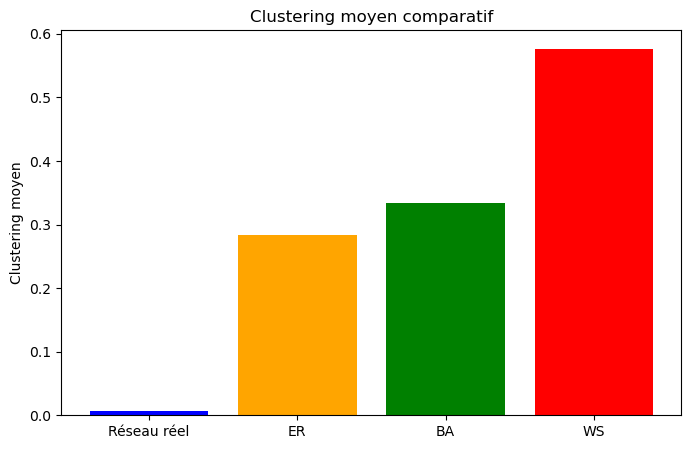

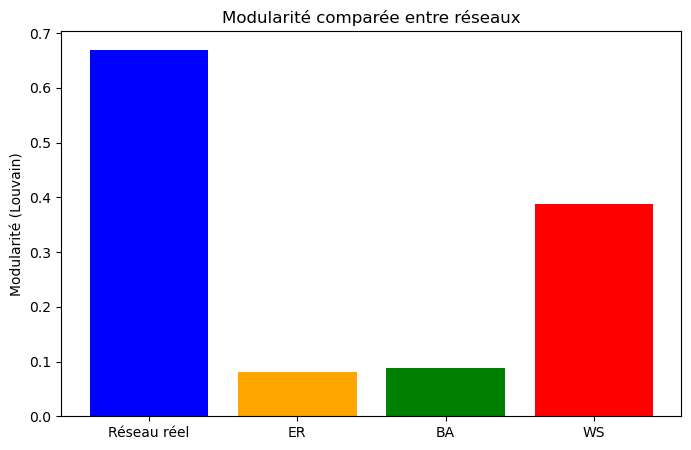

In [282]:
#1 Grapahe G avec une   modularité de  Louvain 
G_real = G 
n_nodes = G_real.number_of_nodes()
n_edges = G_real.number_of_edges()

partition_real = community_louvain.best_partition(G_real, weight='t')
mod_real = community_louvain.modularity(partition_real, G_real, weight='t')
clust_real = nx.average_clustering(G_real, weight='t')
degrees_real = [d for n, d in G_real.degree()]

print(f"Réseau réel : Clustering={clust_real:.4f}, Modularité={mod_real:.4f}")

#2 Random graph models [Réseau Erdos-Rényi, ER]

p_er = 2 * n_edges / (n_nodes*(n_nodes-1))  # probabilité pour un  même nombre d'arêtes
G_er = nx.erdos_renyi_graph(n_nodes, p_er)
partition_er = community_louvain.best_partition(G_er)
mod_er = community_louvain.modularity(partition_er, G_er)
clust_er = nx.average_clustering(G_er)
degrees_er = [d for n, d in G_er.degree()]
print(f"ER : Clustering={clust_er:.4f}, Modularité={mod_er:.4f}")

#3.1 Mechanistic models [Réseau Barabási-Albert, BA]

m_ba = int(n_edges / n_nodes)  # nombre d'arêtes à attacher par nouveau noeud
G_ba = nx.barabasi_albert_graph(n_nodes, m_ba)
partition_ba = community_louvain.best_partition(G_ba)
mod_ba = community_louvain.modularity(partition_ba, G_ba)
clust_ba = nx.average_clustering(G_ba)
degrees_ba = [d for n, d in G_ba.degree()]
print(f"BA : Clustering={clust_ba:.4f}, Modularité={mod_ba:.4f}")

# 3.2 Mechanistic models [Réseau Watts-Strogatz, WS]

k_ws = int(2*n_edges/n_nodes)  # nombre moyen de voisins
p_ws = 0.1  # probabilité de réorganisation
G_ws = nx.watts_strogatz_graph(n_nodes, k_ws, p_ws)
partition_ws = community_louvain.best_partition(G_ws)
mod_ws = community_louvain.modularity(partition_ws, G_ws)
clust_ws = nx.average_clustering(G_ws)
degrees_ws = [d for n, d in G_ws.degree()]
print(f"WS : Clustering={clust_ws:.4f}, Modularité={mod_ws:.4f}")


# Visualisation des dégres des trois modèles 

plt.figure(figsize=(12,6))
plt.hist(degrees_real, bins=range(max(degrees_real)+2), alpha=0.5, label="Réseau réel",color='blue')
plt.hist(degrees_er, bins=range(max(degrees_er)+2), alpha=0.5, label="ER",color='orange')
plt.hist(degrees_ba, bins=range(max(degrees_ba)+2), alpha=0.5, label="BA",color='green')
plt.hist(degrees_ws, bins=range(max(degrees_ws)+2), alpha=0.5, label="WS",color='red')
plt.xlabel("Degré")
plt.ylabel("Nombre de noeuds")
plt.title("Comparaison des distributions de degrés")
plt.xlim(20, 150)
plt.legend()
plt.show()

# Comparaison du clustering entre les trois modeles

clustering_values = [clust_real, clust_er, clust_ba, clust_ws]
labels = ["Réseau réel", "ER", "BA", "WS"]
plt.figure(figsize=(8,5))
plt.bar(labels, clustering_values, color=['blue','orange','green','red'])
plt.ylabel("Clustering moyen")
plt.title("Clustering moyen comparatif")
plt.show()

# Comparaison de la modularité entre les trois modeles

modularity_values = [mod_real, mod_er, mod_ba, mod_ws]
plt.figure(figsize=(8,5))
plt.bar(labels, modularity_values, color=['blue','orange','green','red'])
plt.ylabel("Modularité (Louvain)")
plt.title("Modularité comparée entre réseaux")
plt.show()


# Detection des communautés

Louvain Algorithm

Communauté 1 : 
  5B -> 23 individus
  5A -> 22 individus
  Teachers -> 2 individus
  4B -> 1 individus
Communauté 0 : 
  5B -> 1 individus
  4A -> 21 individus
  4B -> 22 individus
  Teachers -> 2 individus
Communauté 4 : 
  3B -> 22 individus
  3A -> 23 individus
  Teachers -> 2 individus
Communauté 5 : 
  2A -> 23 individus
  2B -> 26 individus
  Teachers -> 2 individus
Communauté 2 : 
  1B -> 25 individus
  Teachers -> 1 individus
Communauté 3 : 
  1A -> 23 individus
  Teachers -> 1 individus


/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_86014/1287966049.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


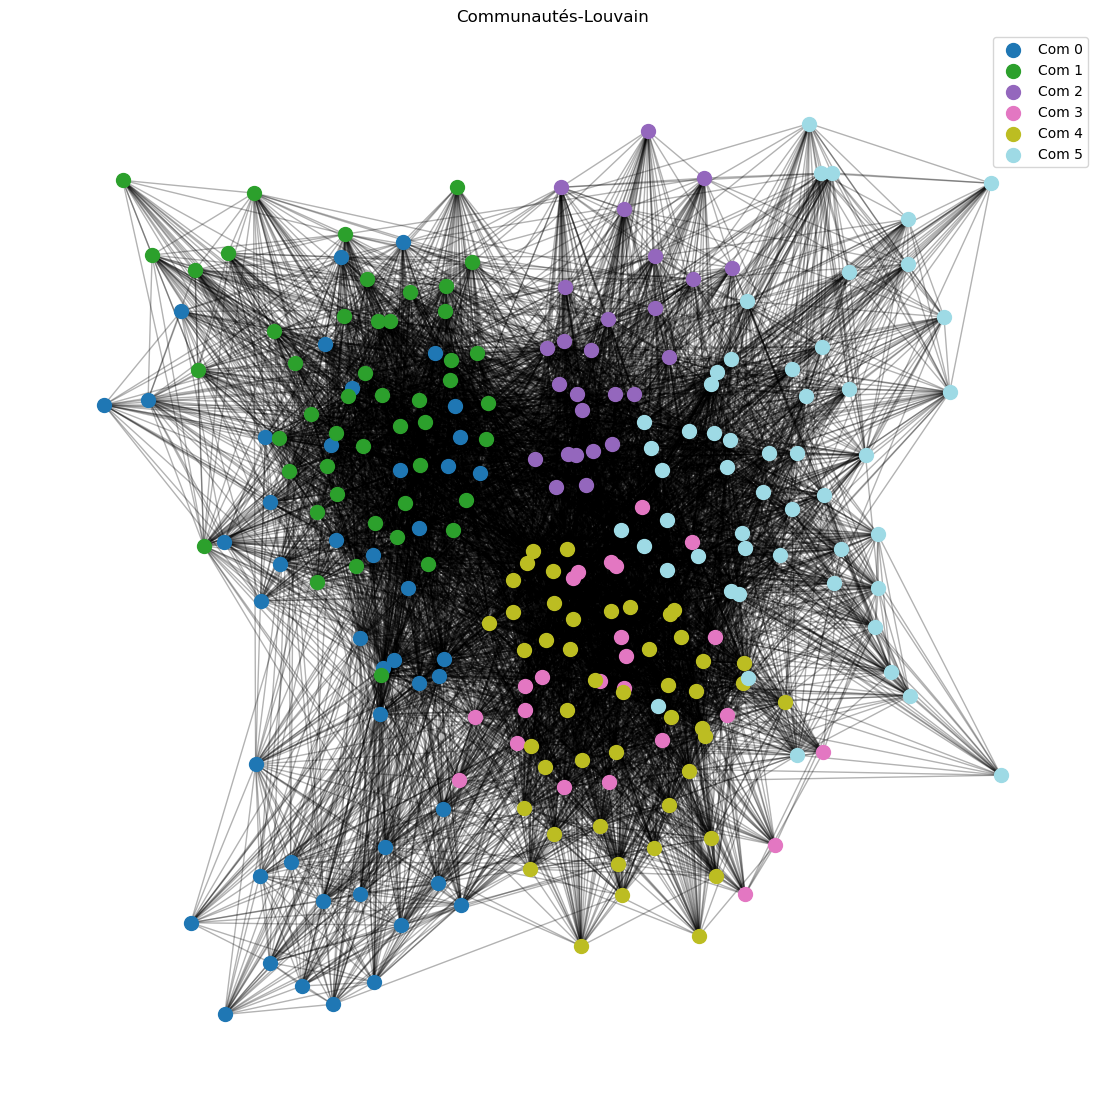

In [283]:
# Détection des communautés avec Louvain
partition_louvain = community_louvain.best_partition(G, weight='t')

# Analyse des catégories par communauté
def categories_per_community(G, partition):
    """
    G : graphe NetworkX
    partition : dict {node: community_index}
    Retourne : dict {community: Counter({category: count})}
    """
    comm_cat_count = defaultdict(Counter)
    for n in G.nodes():
        comm = partition[n]
        cat = G.nodes[n]['category']
        comm_cat_count[comm][cat] += 1
    return comm_cat_count


comm_categories_louvain = categories_per_community(G, partition_louvain)

# Afficher le nombre de categories par commaunauté
for comm, cat_count in comm_categories_louvain.items():
    print(f"Communauté {comm} : ")
    for cat, count in cat_count.items():
        total_nodes=sum(cat_count.values())
        print(f"  {cat} -> {count} individus")

# Visualisation 
def plot_communities(G, partition, title):
    plt.figure(figsize=(14,14))
    pos = nx.spring_layout(G, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    for i, com in enumerate(communities):
        nodes = [n for n in G.nodes() if partition[n] == com]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(i)], node_size=100, label=f"Com {com}")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()

plot_communities(G, partition_louvain, "Communautés-Louvain")


Spectral

/opt/anaconda3/lib/python3.12/site-packages/networkx/algorithms/community/quality.py:253: RuntimeWarning: overflow encountered in scalar multiply
  return L_c / m - resolution * out_degree_sum * in_degree_sum * norm
/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_86014/626543414.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


Modularité Spectral : -9.123174244341715
Communauté 4 : 
  5B -> 24 individus
  Teachers -> 1 individus
Communauté 7 : 
  5A -> 22 individus
  Teachers -> 1 individus
Communauté 2 : 
  4A -> 21 individus
  4B -> 3 individus
  Teachers -> 1 individus
Communauté 9 : 
  3B -> 22 individus
  Teachers -> 1 individus
Communauté 8 : 
  2A -> 23 individus
  Teachers -> 1 individus
Communauté 1 : 
  4B -> 20 individus
  Teachers -> 1 individus
Communauté 0 : 
  1B -> 25 individus
  Teachers -> 1 individus
Communauté 3 : 
  2B -> 22 individus
  Teachers -> 1 individus
Communauté 10 : 
  2B -> 4 individus
Communauté 5 : 
  1A -> 23 individus
  Teachers -> 1 individus
Communauté 6 : 
  3A -> 23 individus
  Teachers -> 1 individus


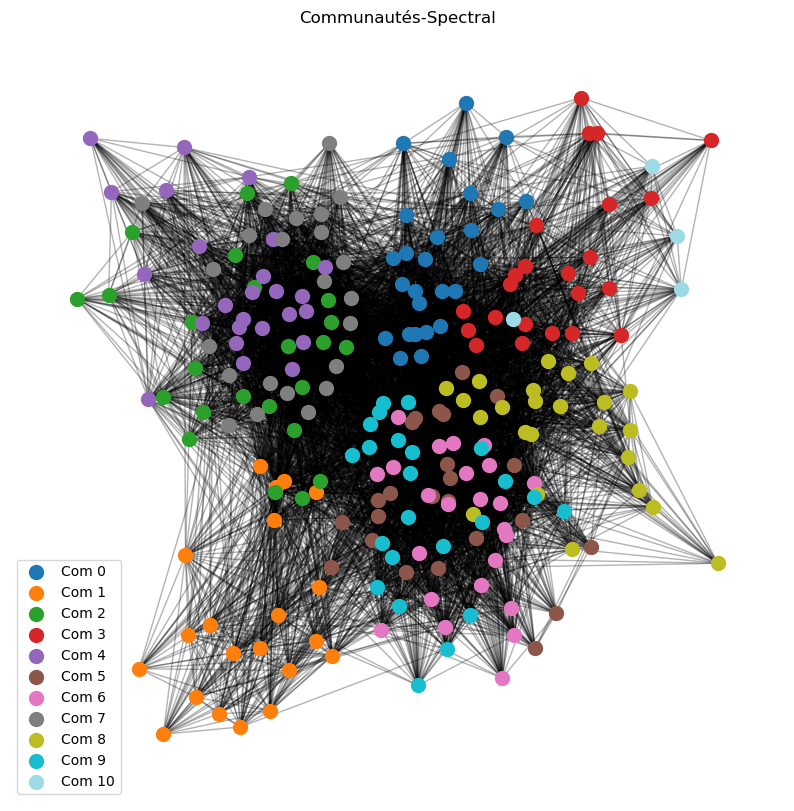

In [284]:

# Définir nombre de communautés (10 classes + Teachers)

k = 11
adj_matrix = nx.to_numpy_array(G, weight='t')
spectral = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
labels_spectral = spectral.fit_predict(adj_matrix)
partition_spectral = {n: labels_spectral[i] for i, n in enumerate(G.nodes())}

# Calcul de modularité approximative
modularity_spectral = nx_community.modularity(G, [ [n for n in G.nodes() if partition_spectral[n]==i] for i in range(k) ], weight='t')
print("Modularité Spectral :", modularity_spectral)

comm_categories_spectral = categories_per_community(G, partition_spectral)

for comm, cat_count in comm_categories_spectral.items():
    print(f"Communauté {comm} : ")
    for cat, count in cat_count.items():
        total_nodes=sum(cat_count.values())
        print(f"  {cat} -> {count} individus")

# Visualisation 
def plot_communities(G, partition, title):
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    for i, com in enumerate(communities):
        nodes = [n for n in G.nodes() if partition[n] == com]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(i)], node_size=100, label=f"Com {com}")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()

plot_communities(G, partition_spectral, "Communautés-Spectral")





Label propagation

Communauté 0 : 
  5B -> 13 individus
  5A -> 22 individus
  Teachers -> 2 individus
Communauté 1 : 
  5B -> 7 individus
  4B -> 1 individus
Communauté 2 : 
  5B -> 2 individus
Communauté 3 : 
  5B -> 2 individus
Communauté 4 : 
  4A -> 21 individus
  Teachers -> 1 individus
Communauté 5 : 
  3B -> 22 individus
  Teachers -> 1 individus
Communauté 6 : 
  2A -> 23 individus
  2B -> 26 individus
  Teachers -> 2 individus
Communauté 7 : 
  4B -> 22 individus
  Teachers -> 1 individus
Communauté 8 : 
  1B -> 25 individus
  Teachers -> 1 individus
Communauté 9 : 
  1A -> 23 individus
  Teachers -> 1 individus
Communauté 10 : 
  3A -> 15 individus
  Teachers -> 1 individus
Communauté 11 : 
  3A -> 8 individus


/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_86014/1181514527.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


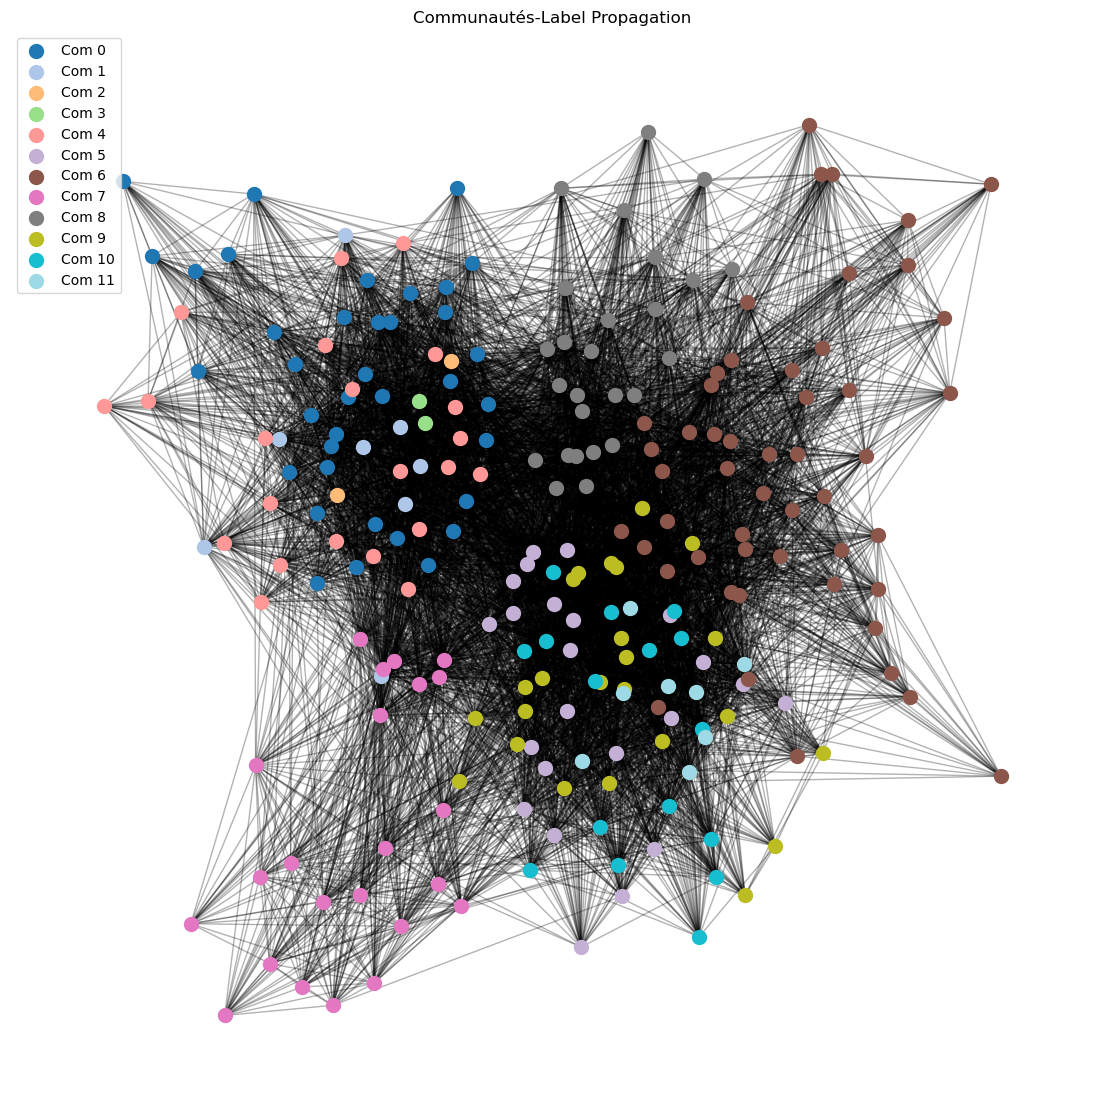

In [285]:
communities_lp = nx_community.asyn_lpa_communities(G, weight='t', seed=42)
partition_lp = {}
for i, com in enumerate(communities_lp):
    for n in com:
        partition_lp[n] = i
        
comm_categories_propagation = categories_per_community(G, partition_lp)

# Afficher le nombre de categories par commaunauté
for comm, cat_count in comm_categories_propagation.items():
    print(f"Communauté {comm} : ")
    for cat, count in cat_count.items():
        total_nodes=sum(cat_count.values())
        print(f"  {cat} -> {count} individus")

# Visualisation 
def plot_communities(G, partition, title):
    plt.figure(figsize=(14,14))
    pos = nx.spring_layout(G, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    for i, com in enumerate(communities):
        nodes = [n for n in G.nodes() if partition[n] == com]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(i)], node_size=100, label=f"Com {com}")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()

plot_communities(G, partition_lp, "Communautés-Label Propagation")




# Dynamique de consensus 

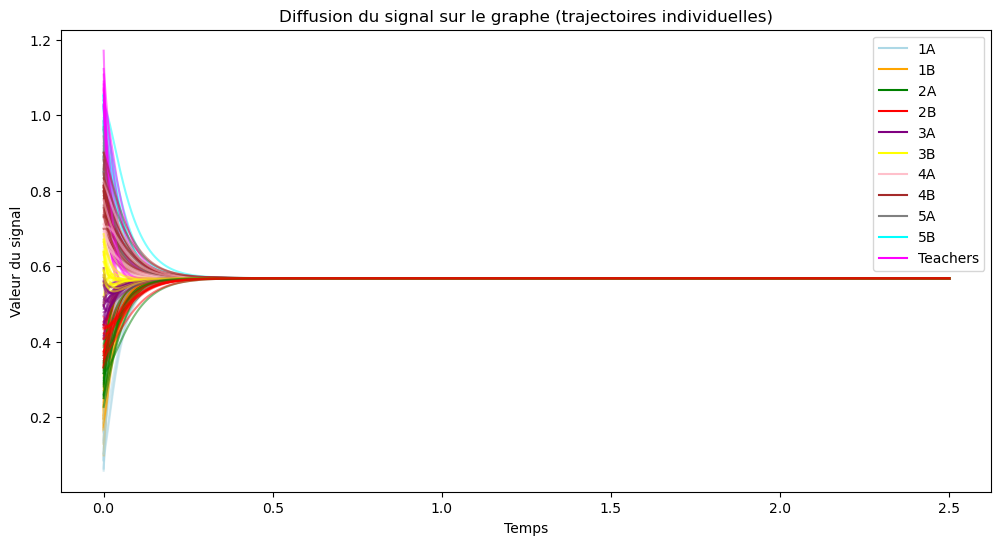

Final consensus value ≈ 0.5682869873518788


In [286]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la

# --- Définir la carte des catégories et des couleurs ---
cat_map = {"1A": 0.1, "1B": 0.2, "2A": 0.3, "2B": 0.4,
           "3A": 0.5, "3B": 0.6, "4A": 0.7, "4B": 0.8,
           "5A": 0.9, "5B": 1.0, "Teachers": 1.1}

color_map = {"1A": "lightblue", "1B": "orange", "2A": "green", "2B": "red",
             "3A": "purple", "3B": "yellow", "4A": "pink", "4B": "brown",
             "5A": "gray", "5B": "cyan", "Teachers": "magenta"}

# --- Laplacien et conditions initiales ---
L = nx.laplacian_matrix(G).astype(float).todense()
x0 = np.array([cat_map[G.nodes[n]["category"]] + 0.05*np.random.randn() for n in G.nodes()])

dt = 0.001
T = 2.5
times = np.arange(0, T + dt, dt)

trajectories = []
x = x0.copy()

for t in times:
    x = la.expm(-L * dt) @ x
    trajectories.append(x)

trajectories = np.array(trajectories)

# --- Tracé des trajectoires individuelles ---
plt.figure(figsize=(12,6))
nodes_list = list(G.nodes())
for i, node in enumerate(nodes_list):
    cat = G.nodes[node]["category"]
    plt.plot(times, trajectories[:, i], color=color_map[cat], alpha=0.5)

plt.xlabel("Temps")
plt.ylabel("Valeur du signal")
plt.title("Diffusion du signal sur le graphe (trajectoires individuelles)")
plt.grid(False)

# --- Légende par catégorie ---
for cat, col in color_map.items():
    plt.plot([], [], color=col, label=cat)
plt.legend()
plt.show()

# --- Consensus final ---
final_consensus = trajectories[-1].mean()
print("Final consensus value ≈", final_consensus)


# Stabilité de Markov

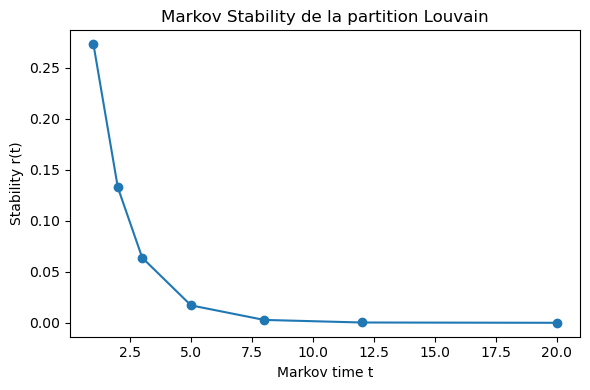

In [293]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- Ordre cohérent des nœuds ---
nodes = list(G.nodes())
N = len(nodes)

A = nx.to_numpy_array(G, nodelist=nodes)
deg = A.sum(axis=1)
deg[deg == 0] = 1  # sécurité

# --- Matrice de transition ---
T = (A.T / deg).T

# --- Distribution stationnaire ---
pi = deg / deg.sum()
Pi = np.diag(pi)

# --- Partition Louvain ---
comms = partition_louvain
K = max(comms.values()) + 1

H = np.zeros((N, K))
node_index = {n: i for i, n in enumerate(nodes)}
for n, c in comms.items():
    H[node_index[n], c] = 1

# --- Markov Stability ---
def markov_stability(T, t, Pi, pi, H):
    P_t = np.linalg.matrix_power(T, t)
    M = Pi @ P_t - np.outer(pi, pi)
    return np.trace(H.T @ M @ H)

times = [1, 2, 3, 5, 8, 12, 20] # pour une densité rho=((2*8317)/(242*241)=0.28), le temps doit être compris entre 1 et 20
stability_values = [markov_stability(T, t, Pi, pi, H) for t in times]

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(times, stability_values, marker='o')
plt.xlabel("Markov time t")
plt.ylabel("Stability r(t)")
plt.title("Markov Stability de la partition Louvain")
plt.grid(False)
plt.tight_layout()
plt.show()


# Determination de la matrice de contact

In [ ]:
class_contact_time = defaultdict(float)

# Grouper par paire de personnes
for (i, j), group in df.groupby([1, 2]):
    Si, Sj = group[3].iloc[0], group[4].iloc[0]  # classes de i et j
    total_t = len(group) * 20  # chaque ligne = 20 secondes de contact
    class_contact_time[(Si, Sj)] += total_t

# Liste des classes uniques
classes = list(set(df[3].unique()).union(set(df[4].unique())))
# Créer une matrice DataFrame
contact_matrix = pd.DataFrame(0, index=classes, columns=classes, dtype=float)
   
# Remplir la matrice
for (c1, c2), t in class_contact_time.items():
    contact_matrix.loc[c1, c2] += t
    if c1 != c2:
        contact_matrix.loc[c2, c1] += t  # symétrie

# Convertir en heures pour lisibilité
contact_matrix = contact_matrix / 3600

# Afficher la matrice
print(contact_matrix)


                 3A         5B         3B         1B         4B         2B  \
3A        47.327778   0.500000  18.422222   1.988889   1.255556   6.094444   
5B         0.500000  45.938889   1.416667   2.816667   3.455556   0.333333   
3B        18.422222   1.416667  57.272222   1.394444   1.427778   2.994444   
1B         1.988889   2.816667   1.394444  93.516667   1.405556   6.116667   
4B         1.255556   3.455556   1.427778   1.405556  26.666667   0.266667   
2B         6.094444   0.333333   2.994444   6.116667   0.266667  62.050000   
4A         0.494444   6.216667   1.961111   4.516667   7.322222   0.888889   
2A         5.655556   0.194444   3.650000   3.905556   0.322222  17.805556   
5A         0.672222  16.111111   0.933333   3.283333   0.766667   0.244444   
Teachers   3.361111   2.244444   2.455556   7.661111   1.138889   4.122222   
1A         4.344444   0.616667   2.105556   9.711111   1.022222   5.666667   

                 4A         2A         5A  Teachers         1A 

Visualisation de la matrice de contact

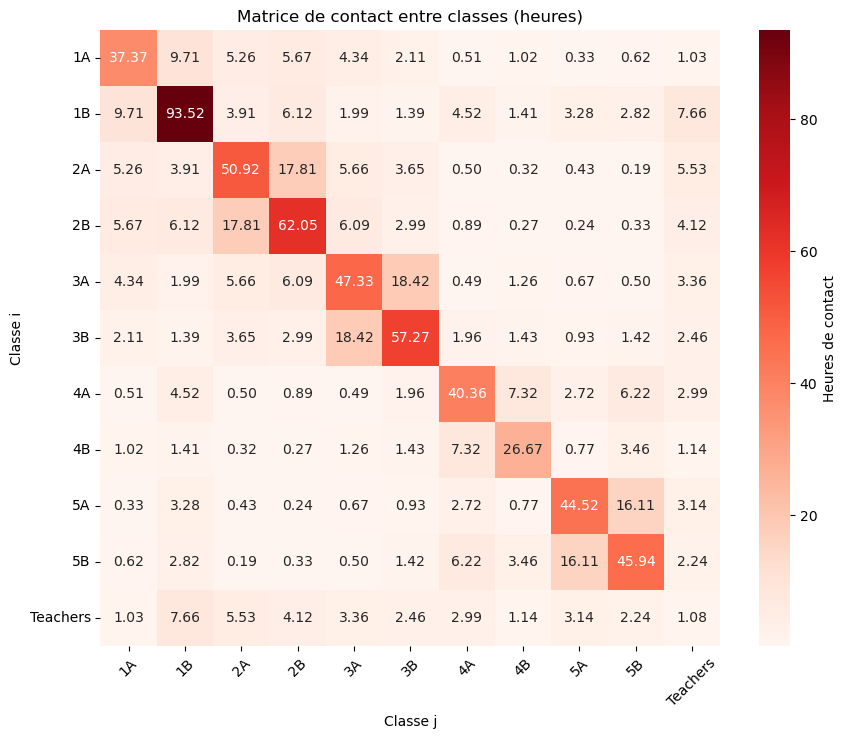

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Trier les classes pour un affichage cohérent ---
classes_sorted = sorted(contact_matrix.index)
contact_matrix = contact_matrix.loc[classes_sorted, classes_sorted]

# --- Tracé avec seaborn ---
plt.figure(figsize=(10,8))
sns.heatmap(contact_matrix, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Heures de contact'})
plt.title("Matrice de contact entre classes (heures)")
plt.xlabel("Classe j")
plt.ylabel("Classe i")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()


# Simulation d'un process SIR entre le noeud central(1551, 3B) et un noeud peripherique(1609,2B)

Affichage du noeud central

In [ ]:
degree_dict = dict(G.degree())
max_degree = max(degree_dict.values())
central_nodes = [n for n, d in degree_dict.items() if d == max_degree]
central_node = central_nodes[0]
print("Noeud central :", central_node, "Catégorie :", G.nodes[central_node]['category'], "Degré :", max_degree)


Noeud central : 1551 Catégorie : 3B Degré : 134


Affichage du noeud peripherique

In [297]:
min_degree = min(degree_dict.values())
peripheral_nodes = [n for n, d in degree_dict.items() if d == min_degree]
peripheral_node = peripheral_nodes[0]

print("Noeud périphérique :", peripheral_node, "Catégorie :", G.nodes[peripheral_node]['category'], "Degré :", min_degree) 
 


Noeud périphérique : 1609 Catégorie : 2A Degré : 20


Code de simulation SIR

In [ ]:
def simulate_sir(G, initial_node, beta=0.03, gamma=0.01, max_steps=5000,max_seed=42):
    state = {n: 'S' for n in G.nodes()}
    state[initial_node] = 'I'
    history = []

    for t in range(max_steps):
        new_state = state.copy()

        for node in G.nodes():
            if state[node] == 'I':
                for neighbor in G.neighbors(node):
                    if state[neighbor] == 'S' and random.random() < beta:
                        new_state[neighbor] = 'I'

                if random.random() < gamma:
                    new_state[node] = 'R'

        state = new_state

        S = sum(1 for s in state.values() if s == 'S')
        I = sum(1 for s in state.values() if s == 'I')
        R = sum(1 for s in state.values() if s == 'R')

        history.append((S, I, R))

        #  arrêt si l’épidémie s’éteint
        if I == 0:
            break

    return history


Affichage des pic d'infection pour les deux noeuds

In [ ]:
history_central = simulate_sir(G, central_node,max_seed=42)
history_peripheral = simulate_sir(G, peripheral_node,max_seed=42)

print("Propagation depuis le noeud central :")
print("Pic d'infectés :", max(h[1] for h in history_central))

print("\nPropagation depuis le noeud périphérique :")
print("Pic d'infectés :", max(h[1] for h in history_peripheral))



Propagation depuis le noeud central :
Pic d'infectés : 233

Propagation depuis le noeud périphérique :
Pic d'infectés : 229


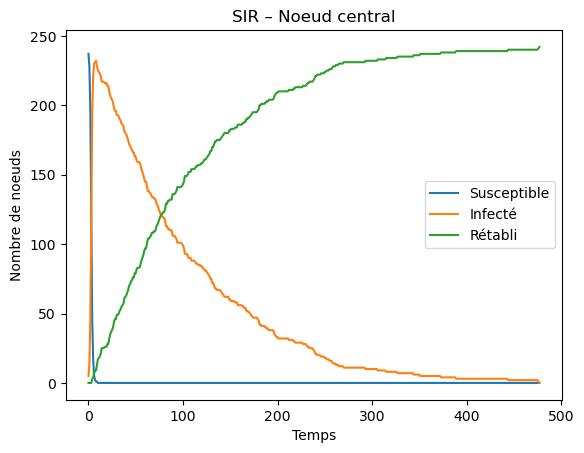

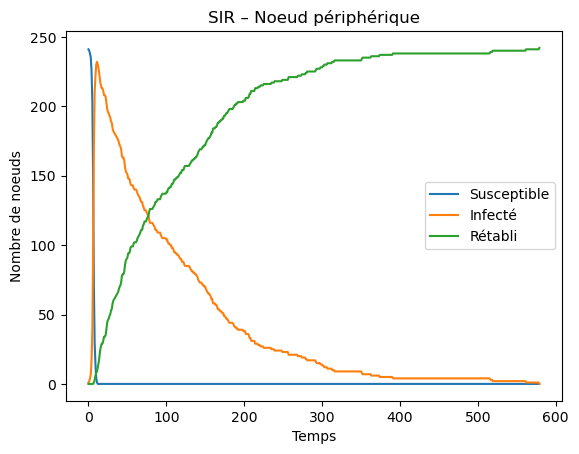

In [ ]:
import matplotlib.pyplot as plt

def plot_sir(history, title):
    S, I, R = zip(*history)
    plt.plot(S, label='Susceptible')
    plt.plot(I, label='Infecté')
    plt.plot(R, label='Rétabli')
    plt.legend()
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Nombre de noeuds")
    plt.show()

plot_sir(history_central, "SIR – Noeud central")
plot_sir(history_peripheral, "SIR – Noeud périphérique")
